# Supercon v2: Novel Superconductor Discovery


In [21]:
from sctk.materials import Material, Superconductor, PeriodicTable
from sctk.structure import composition_distance

from sctk.notebook import init_notebook

init_notebook()

In [2]:
import pandas as pd
from tqdm import tqdm
import pickle as pkl
import os
import numpy as np
import sklearn
from glob import glob
import matplotlib.pyplot as plt

### Initialize matplotlib

In [3]:
# This sets the pdf rendering to be pdflatex-compatible:
plt.rcParams.update({
    'pgf.texsystem' : 'pdflatex'
})

# use seaborn plot style:
plt.style.use('seaborn')

FIGURES_DIR = './figures2'

## Load SuperCon v2 and v1 data:

In [6]:
CLEANED_SUPERCON_V2_CSV = './data/Supercon-master/supercon2_cleaned.csv'
CLEANED_SUPERCON_V1_CSV = './data/Supercon-master/supercon1_cleaned.csv'

SCREEN_MATERIAL_DIR = './data/sctk_structures/screening'

In [7]:
supercon2_df = pd.read_csv(CLEANED_SUPERCON_V2_CSV, index_col=False)
supercon1_df = pd.read_csv(CLEANED_SUPERCON_V1_CSV, index_col=False)

total_supercon_df = pd.concat([supercon2_df, supercon1_df])

display(total_supercon_df)

,Material,Substitutions,Tc (K),Pressure (GPa),Classes,Shape,Substrate,DOI
0,In O x,{'x': []},2.80,0.0,['Oxides'],films,NaN,10.1103/physrevb.99.054515
1,In O,{},2.00,0.0,['Alloys'],films,NaN,10.1134/1.568304
2,Pr Ru 2 Si 2,{},14.00,0.0,['Alloys'],NaN,NaN,10.1088/0953-8984/12/34/307
3,Lu 3 Os 4 Ge 13,{},2.85,0.0,['Alloys'],NaN,NaN,NaN
4,La Mn O 3.04,{},125.00,0.0,['Oxides'],NaN,NaN,10.1103/physrevlett.87.127206
...,...,...,...,...,...,...,...,...
12413,La 1.78 Sr 0.22 Cu 0.998 Zn 0.003 O 4,{},19.25,0.0,"['Oxides', 'Cuprates']",NaN,NaN,10.1038/s41524-018-0085-8
12414,Nb 0.96 Ta 0.04,{},8.87,0.0,"['Oxides', 'Cuprates']",NaN,NaN,10.1038/s41524-018-0085-8
12415,Pb 2 Sr 2 Ho 0.5 Ca 0.5 Cu 2.982 Al 0.018 O 8,{},63.60,0.0,"['Oxides', 'Cuprates']",NaN,NaN,10.1038/s41524-018-0085-8
12416,Yb 0.5 Pr 0.5 Ba 2 Cu 3 O 6.9,{},34.80,0.0,"['Oxides', 'Cuprates']",NaN,NaN,10.1038/s41524-018-0085-8


## Index Dataset by Composition:

In [155]:
composition_map = {}

def get_composition_atoms(m):
    return tuple(sorted(set(str(elem) for elem in m.get_composition().keys())))

for _, row in tqdm(total_supercon_df.iterrows()):
    row_material = Material(row['Material'])
    row_material_subs = eval(row['Substitutions'])
    first_sub = { k : v[0] for k,v in row_material_subs.items() if v }
    row_material.substitute(first_sub)
    
    comp_items = get_composition_atoms(row_material)
    pristine_row_material = row_material.get_pristine_material()
    
    if pristine_row_material is None:
        continue
    
    pristine_comp_items = get_composition_atoms(pristine_row_material)
    
    if comp_items not in composition_map:
        composition_map[comp_items] = []
    
    if pristine_comp_items not in composition_map:
        composition_map[pristine_comp_items] = []
        
    composition_map[comp_items].append(pristine_row_material)
    if comp_items != pristine_comp_items:
        composition_map[pristine_comp_items].append(pristine_row_material)

36299it [00:08, 4083.98it/s]


## Load ALIGNN Classifier Model and Data Support SVM model:

In [133]:
ALIGNN_CLASSIFIER_OUTPUT_DIR = './data/sctk_structures/alignn_sc_classifier_output'
ALIGNN_REGRESSION_OUTPUT_DIR = './data/sctk_structures/alignn_sc_regression_output'

CLASSIFIER_MODEL_PATH = os.path.join(ALIGNN_CLASSIFIER_OUTPUT_DIR, 'checkpoint_80.pt')
CLASSIFIER_CONFIG_PATH = os.path.join(ALIGNN_CLASSIFIER_OUTPUT_DIR, 'config.json')

REGRESSION_MODEL_PATH = os.path.join(ALIGNN_REGRESSION_OUTPUT_DIR, 'checkpoint_160.pt')
REGRESSION_CONFIG_PATH = os.path.join(ALIGNN_REGRESSION_OUTPUT_DIR, 'config.json')
REGRESSION_DATA_DIR = './data/sctk_structures/alignn_sc_regression_data'

SUPPORT_SVM_PATH = './models/support_svm_model.pkl'

In [134]:
from alignn.models.alignn import ALIGNN, ALIGNNConfig
from jarvis.core.atoms import Atoms
from alignn.graphs import Graph
from tqdm import tqdm
import torch
import pickle
import json

from alignn.train import thresholded_output_transform

def load_model(path, config_path=None, model_config=None):
    device = "cpu"
    if torch.cuda.is_available():
        device = torch.device("cuda")
    if config_path:
        with open(config_path, 'r') as f:
            model_config = json.load(f)
    if model_config:
        alignn_config = ALIGNNConfig(**model_config['model'])
        #print(dict(alignn_config))
        model = ALIGNN(alignn_config)
    else:
        model = ALIGNN(ALIGNNConfig(name="alignn", output_features=1))
    model.load_state_dict(torch.load(path, map_location=device)["model"])
    model.eval()
    
    return model

def classifier_serve(model, poscar_file, return_logits=False):
    cutoff = 8.0
    max_neighbors = 12
    device = "cpu"
    if torch.cuda.is_available():
        device = torch.device("cuda")
    
    atoms = Atoms.from_poscar(poscar_file)
    g, lg = Graph.atom_dgl_multigraph(
        atoms, cutoff=float(cutoff), max_neighbors=max_neighbors,
    )
    out_data = (
        model([g.to(device), lg.to(device)])
        .detach()
        .cpu()
        .numpy()
        .flatten()
        .tolist()
    )
    
    # Note: The model returns unrounded logits, which
    # must be converted into probabilities:
    if return_logits:
        return np.array(out_data)
    
    return np.exp(np.array(out_data))

def regression_serve(model, poscar_file):
    cutoff = 8.0
    max_neighbors = 12
    device = "cpu"
    if torch.cuda.is_available():
        device = torch.device("cuda")
    
    atoms = Atoms.from_poscar(poscar_file)
    g, lg = Graph.atom_dgl_multigraph(
        atoms, cutoff=float(cutoff), max_neighbors=max_neighbors,
    )
    out_data = (
        model([g.to(device), lg.to(device)])
        .detach()
        .cpu()
        .numpy()
        .flatten()
        .tolist()
    )
    
    return out_data


In [135]:
model = load_model(CLASSIFIER_MODEL_PATH, CLASSIFIER_CONFIG_PATH)
reg_model = load_model(REGRESSION_MODEL_PATH, REGRESSION_CONFIG_PATH)

## Screen Materials:

In [165]:
from ase.io import read
from pprint import pprint
from itertools import combinations

screen_materials = glob(os.path.join(SCREEN_MATERIAL_DIR,'*.poscar'))

def ordered_subsets(iterable):
    for n in range(1,len(iterable)+1):
        for sublist in combinations(iterable,n):
            yield sublist

screen_data = []
for mat_file in tqdm(screen_materials):
    
    mp_id = os.path.splitext(os.path.split(mat_file)[-1])[0]
    atoms = read(mat_file)
    atoms_mat = Material(atoms.get_chemical_formula())
    
    comp_items = get_composition_atoms(atoms_mat)
    
    # determine composition distance to closest material in dataset:
    closest_dist, closest_material = 2.0, None
    close_materials = [
        (composition_distance(atoms_mat, data_mat, normalized=True),
         composition_distance(atoms_mat, data_mat, normalized=False), 
         data_mat)
        for comp_subset in ordered_subsets(comp_items)
        for data_mat in (composition_map[comp_subset]
                        if comp_subset in composition_map else [] )
    ]
    
    if close_materials:
        closest_dist, _, closest_material = \
            min(close_materials, key = lambda x : (x[0],x[1]))
    
    # obtain classifier prediction:
    pred = classifier_serve(model, mat_file, return_logits=True)[1]
    pred_rounded = np.round(np.exp(pred))
    
    screen_data.append({
        'mp-id' : mp_id,
        'Unitcell' : atoms_mat.str(pretty=False),
        'Closest Known Superconductor': closest_material.str(pretty=False) \
                                            if closest_material is not None else None,
        'Closest Superconductor Distance': closest_dist,
        'Predicted Superconductor Logit' : pred,
        'Predicted Superconductor' : pred_rounded
    })
        

100%|████████████████████████████████████████████████| 24366/24366 [3:55:06<00:00,  1.73it/s]


In [169]:
screen_data_df = pd.DataFrame(screen_data)
screen_data_df = screen_data_df.rename(columns={'Closest Material Distance' : 'Closest Superconductor Distance'})
display(screen_data_df)

,mp-id,Unitcell,Closest Known Superconductor,Closest Superconductor Distance,Predicted Superconductor Logit,Predicted Superconductor
0,mp-1225069,AlCo3Er2,Co3,1.000000,-9.942762e+00,0.0
1,mp-1000,BaTe,Ba,1.000000,-2.554481e+01,0.0
2,mp-10000,Hf4S2,Hf,0.666667,-1.466816e+01,0.0
3,mp-10004,Mo12P4,Mo3P,0.000000,-4.768370e-07,1.0
4,mp-10008,Ca7Ge,Ca2,0.250000,-1.815738e+01,0.0
...,...,...,...,...,...,...
24361,mp-772950,Cr12O48Ti8,CrO2,0.313725,-1.592766e+01,0.0
24362,mp-772980,Li24O36Te8,O7,0.941176,-9.851643e+00,0.0
24363,mp-773019,O29V12,V2O5,0.013937,-1.246185e+01,0.0
24364,mp-773080,O30V7W6,V2O5,0.279070,-1.692869e+01,0.0


In [170]:
#screen_data_df.to_csv(os.path.join(SCREEN_MATERIAL_DIR,'screened_materials2.csv'),
#                      index=False)

In [8]:
read_screen_data = pd.read_csv(os.path.join(SCREEN_MATERIAL_DIR, 
                                            'screened_materials2.csv'))
display(read_screen_data)

,mp-id,Unitcell,Closest Known Superconductor,Closest Superconductor Distance,Predicted Superconductor Logit,Predicted Superconductor
0,mp-1225069,AlCo3Er2,Co3,1.000000,-9.942762e+00,0.0
1,mp-1000,BaTe,Ba,1.000000,-2.554481e+01,0.0
2,mp-10000,Hf4S2,Hf,0.666667,-1.466816e+01,0.0
3,mp-10004,Mo12P4,Mo3P,0.000000,-4.768370e-07,1.0
4,mp-10008,Ca7Ge,Ca2,0.250000,-1.815738e+01,0.0
...,...,...,...,...,...,...
24361,mp-772950,Cr12O48Ti8,CrO2,0.313725,-1.592766e+01,0.0
24362,mp-772980,Li24O36Te8,O7,0.941176,-9.851643e+00,0.0
24363,mp-773019,O29V12,V2O5,0.013937,-1.246185e+01,0.0
24364,mp-773080,O30V7W6,V2O5,0.279070,-1.692869e+01,0.0


In [194]:
pred_sup_index = (read_screen_data['Predicted Superconductor'] == 1) & \
                 (read_screen_data['Closest Superconductor Distance'] > 0.0) & \
                 (read_screen_data['Closest Superconductor Distance'] < 1.0)
pred_sup_df = read_screen_data[pred_sup_index]

display(pred_sup_df.sort_values(by='Predicted Superconductor Logit', ascending=False))

,mp-id,Unitcell,Closest Known Superconductor,Closest Superconductor Distance,Predicted Superconductor Logit,Predicted Superconductor
24351,mp-771950,K8Mn4O16,KMnO4,0.238095,0.000000,1.0
21790,mp-1197864,Ge26Ir8Lu6,Lu5Ir4Ge10,0.247368,0.000000,1.0
8557,mp-1008776,C2Sr,SrC6,0.380952,0.000000,1.0
22536,mp-1218269,Cu4La3O10Sr,La2SrCu2O6,0.101010,0.000000,1.0
22535,mp-1218244,Cu2La3O8Sr,La2SrCu2O6,0.116883,0.000000,1.0
...,...,...,...,...,...,...
4354,mp-999298,AuPd3,Pd,0.500000,-0.683894,1.0
18498,mp-23162,Cl2Zr,Cl2,0.666667,-0.686887,1.0
14373,mp-985588,ClFe,FeCl4,0.600000,-0.687928,1.0
21542,mp-21011,As6Ce8,Ce,0.857143,-0.689498,1.0


In [221]:
# export prediction table to html:
pred_sup_df.sort_values(by='Predicted Superconductor Logit', ascending=False)\
    .to_html('./figures2/superconductor_predictions.html')

## Enrich Predictions with Materials Project Data:

In [58]:
from sctk.databases import MaterialsProject

#mp_ids = [ 'mp-2516584' ]
mp_ids = [ row['mp-id'] for _, row in pred_sup_df.iterrows() ]

with MaterialsProject() as mp:
    r = mp.query({'material_ids' : ['mp-771777'], 'fields' : ['symmetry']})
    print(r['mp-771777']['symmetry'].crystal_system, 
          r['mp-771777']['symmetry'].symbol)
    results = mp.query({'material_ids' : mp_ids, 'fields' : [
        'formula_pretty', 
        'material_id', 
        'energy_above_hull',
        'is_stable',
        'symmetry',
        'theoretical']})

result_map = { str(k) : v for k,v in results.items() }

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Trigonal R-3m


Retrieving SummaryDoc documents:   0%|          | 0/626 [00:00<?, ?it/s]

In [62]:
enriched_predictions = []
for _, row in pred_sup_df.iterrows():
    mp_id = row['mp-id']
    result_data = result_map[mp_id]
    enriched_data = {
        'mp-id' : row['mp-id'],
        'Formula': result_data['formula_pretty'],
        'Space Group': [
            result_data['symmetry'].symbol,
            result_data['symmetry'].crystal_system,
        ],
        'Stable' : result_data['is_stable'],
        'Energy Above Hull (eV/atom)': result_data['energy_above_hull'],
        'Experimentally Observed' : not result_data['theoretical'],
        'Closest Known Superconductor' : row['Closest Known Superconductor'],
        'Closest Superconductor Distance' : row['Closest Superconductor Distance'],
        'Log Probability of Superconductivity': row['Predicted Superconductor Logit']
    }
    enriched_predictions.append(enriched_data)
    
enriched_pred_df = pd.DataFrame(enriched_predictions)
display(enriched_pred_df)

,mp-id,Formula,Space Group,Stable,Energy Above Hull (eV/atom),Experimentally Observed,Closest Known Superconductor,Closest Superconductor Distance,Log Probability of Superconductivity
625,mp-771950,K2MnO4,"[P2_1/c, Monoclinic]",False,0.005739,False,KMnO4,0.238095,0.000000
547,mp-1197864,Lu3Ge13Ir4,"[Pm-3n, Cubic]",False,0.007280,True,Lu5Ir4Ge10,0.247368,0.000000
211,mp-1008776,SrC2,"[R-3m, Trigonal]",False,0.201502,False,SrC6,0.380952,0.000000
568,mp-1218269,SrLa3(Cu2O5)2,"[Pm, Monoclinic]",False,0.025728,False,La2SrCu2O6,0.101010,0.000000
567,mp-1218244,SrLa3(CuO4)2,"[Amm2, Orthorhombic]",False,0.039743,False,La2SrCu2O6,0.116883,0.000000
...,...,...,...,...,...,...,...,...,...
117,mp-999298,Pd3Au,"[Pm-3m, Cubic]",True,0.000000,False,Pd,0.500000,-0.683894
457,mp-23162,ZrCl2,"[R3m, Trigonal]",True,0.000000,True,Cl2,0.666667,-0.686887
343,mp-985588,FeCl,"[Pm-3m, Cubic]",False,0.916894,False,FeCl4,0.600000,-0.687928
540,mp-21011,Ce4As3,"[I-43d, Cubic]",False,0.028099,True,Ce,0.857143,-0.689498


In [63]:
enriched_pred_df.sort_values(
        by='Log Probability of Superconductivity', 
        ascending=False)\
    .to_html('./figures2/enriched_superconductor_predictions.html')

# Visualize Distribution of Predictions:

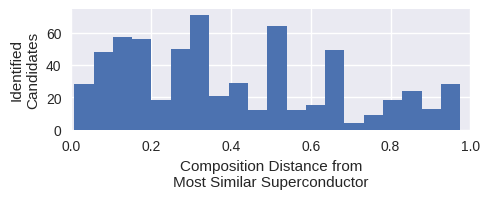

In [186]:
from scipy.stats import gaussian_kde

%matplotlib inline
# Show that predicted superconductors tend to be very similar in composition
# (plot prob vs. distance from known superconductor)

composition_dists = pred_sup_df['Closest Superconductor Distance']
prediction_logits = pred_sup_df['Predicted Superconductor Logit']

plt.figure(figsize=(5,2.1))
#plt.grid()
plt.hist(composition_dists, bins=20)
plt.xlim((0.0, 1.0))
plt.ylabel('Identified\nCandidates')
plt.xlabel('Composition Distance from\nMost Similar Superconductor')
plt.tight_layout()

# save figure:
if FIGURES_DIR is not None:
    figpath = os.path.join(FIGURES_DIR,'supercon2_candidate_distribution.pdf')
    plt.savefig(figpath, backend='pgf')
plt.show()

In [213]:
selected_examples = {
    'mp-1025564',
    'mp-10898',
    'mp-1221439',
    'mp-573601',
    'mp-28280',
    'mp-1224184',
    'mp-672238',
    'mp-1221697',
    'mp-1228895',
    'mp-1213556',
    'mp-1222266',
    'mp-1079796',
    'mp-1218331',
    'mp-1221697',
    'mp-1228895',
    'mp-1213556',
    'mp-1222266',
    'mp-1079796',
    'mp-1218331',
    'mp-1021328',
    'mp-11494',
    'mp-1226890',
    'mp-22266',
    'mp-1184695',
    'mp-9605',
    'mp-1207779',
    'mp-653995',
    'mp-1663521',
    'mp-2805',
    'mp-16791',
    'mp-1103958',
    'mp-1227704',
    'mp-643270',
    'mp-1216517',
    'mp-1224291',
    'mp-1190843',
    'mp-292',
    'mp-28385',
    'mp-862665',
    'mp-1220204',
    'mp-1185154',
    'mp-1220417',
    'mp-1585',
    'mp-1216575',
    'mp-1091395',
    'mp-1184672',
    'mp-1120790',
    'mp-1214891',
    'mp-1224195',
    'mp-20603',
    'mp-1196837',
    'mp-1025156',
    'mp-12763',
    'mp-20109',
    'mp-1079348'
}

In [214]:
selected_pred_idx = enriched_pred_df['mp-id'].apply(lambda x :  x in selected_examples)
selected_pred_df = enriched_pred_df[selected_pred_idx]


In [215]:
stable_idx = (selected_pred_df['Energy Above Hull (eV/atom)'] < 0.05)
selected_stable_pred_df = selected_pred_df[stable_idx]\
    .sort_values(by='Log Probability of Superconductivity', ascending=False)

selected_stable_pred_df['Formula'] = \
    selected_stable_pred_df['Formula'].transform(lambda m : Material(m).str(fmt='latex'))
selected_stable_pred_df['Closest Known Superconductor'] = \
    selected_stable_pred_df['Closest Known Superconductor']\
    .transform(lambda m : Material(m).str(fmt='latex'))

selected_stable_pred_df['Experimentally Observed'] = \
    selected_stable_pred_df['Experimentally Observed'].transform(lambda b : 'Yes' if b else 'No')
selected_stable_pred_df['Stable'] = \
    selected_stable_pred_df['Stable'].transform(lambda b : 'Yes' if b else 'No')
selected_stable_pred_df['Energy Above Hull (eV/atom)'] = \
    selected_stable_pred_df['Energy Above Hull (eV/atom)'].transform(lambda x : round(x,3))

selected_stable_pred_df = selected_stable_pred_df.rename(columns={
    'mp-id' : 'MPID',
    'Experimentally Observed' : 'Observed',
    'Energy Above Hull (eV/atom)' : 'Ehull (eV/atom)',
    'Closest Known Superconductor' : 'Closest Supercond.'
})



In [216]:
display(selected_stable_pred_df)

,MPID,Formula,Space Group,Stable,Ehull (eV/atom),Observed,Closest Supercond.,Closest Superconductor Distance,Log Probability of Superconductivity
219,mp-672238,CeCuSb$_{2}$,"[P4/nmm, Tetragonal]",Yes,0.000,Yes,Cu$_{2}$Sb,0.833333,0.000000e+00
550,mp-1025564,LuAl$_{2}$Pd$_{5}$,"[I4/mmm, Tetragonal]",Yes,0.000,No,Pd,0.750000,-1.192093e-07
76,mp-10898,ScAlNi$_{2}$,"[Fm-3m, Cubic]",Yes,0.000,Yes,Ni$_{3}$Al,0.500000,-3.576278e-07
621,mp-573601,Th$_{7}$Ru$_{3}$,"[P6_3mc, Hexagonal]",Yes,0.000,Yes,Th,0.600000,-4.768360e-06
618,mp-28280,K$_{5}$V$_{3}$O$_{10}$,"[P4_12_12, Tetragonal]",Yes,0.000,Yes,KO$_{3}$,0.388889,-6.079655e-06
86,mp-1224184,HfZrB$_{4}$,"[Pmmm, Orthorhombic]",Yes,0.000,No,HfB$_{2}$,0.333333,-2.944426e-05
614,mp-1228895,AlGaSb$_{2}$,"[R3m, Trigonal]",No,0.012,No,AlSb,0.500000,-3.370671e-04
348,mp-1222266,Lu$_{3}$S$_{4}$,"[I4/mmm, Tetragonal]",Yes,0.000,No,LuS,0.142857,-4.830386e-04
456,mp-1079796,Ti$_{3}$Pd,"[Pm-3n, Cubic]",Yes,0.000,No,Ti,0.500000,-5.776405e-04
569,mp-1218331,Sr$_{3}$CaSi$_{8}$,"[R32, Trigonal]",No,0.017,No,Sr(Si)$_{2}$,0.166667,-6.618693e-04


In [217]:


print(selected_stable_pred_df[['MPID', 
                               'Formula', 
                               'Stable',
                               'Observed',
                               'Ehull (eV/atom)',
                               'Closest Supercond.']].to_latex(index=False, escape=False))

\begin{tabular}{llllrl}
\toprule
      MPID &                          Formula & Stable & Observed &  Ehull (eV/atom) & Closest Supercond. \\
\midrule
 mp-672238 &                     CeCuSb$_{2}$ &    Yes &      Yes &            0.000 &         Cu$_{2}$Sb \\
mp-1025564 &               LuAl$_{2}$Pd$_{5}$ &    Yes &       No &            0.000 &                 Pd \\
  mp-10898 &                     ScAlNi$_{2}$ &    Yes &      Yes &            0.000 &         Ni$_{3}$Al \\
 mp-573601 &                 Th$_{7}$Ru$_{3}$ &    Yes &      Yes &            0.000 &                 Th \\
  mp-28280 &           K$_{5}$V$_{3}$O$_{10}$ &    Yes &      Yes &            0.000 &           KO$_{3}$ \\
mp-1224184 &                      HfZrB$_{4}$ &    Yes &       No &            0.000 &          HfB$_{2}$ \\
mp-1228895 &                     AlGaSb$_{2}$ &     No &       No &            0.012 &               AlSb \\
mp-1222266 &                  Lu$_{3}$S$_{4}$ &    Yes &       No &            0.000 &

/tmp/ipykernel_8056/1501875972.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(selected_stable_pred_df[['MPID',


In [191]:
view_examples = [
    'mp-1021328',
    'mp-1216517',
    'mp-1224195',
    'mp-1585',
    'mp-1190843',
    'mp-1103958'
]

In [192]:

example_tc_preds = {}

for example in view_examples:
    example_poscar_path = os.path.join(SCREEN_MATERIAL_DIR, example+'.poscar')
    example_tc_preds[example] = regression_serve(reg_model, example_poscar_path)

H₄C 50.96551513671875 5.891541481018066
V₃B₁₀₀ 11.95142936706543 12.48904800415039
HoUTe₆ 2.3843331336975098 1.6980037689208984
V₃Co 3.967752695083618 0.8763835430145264
NpH₃ 15.423219680786133 1.6722460985183716
GdIr₃ 8.100358963012695 0.6446661949157715


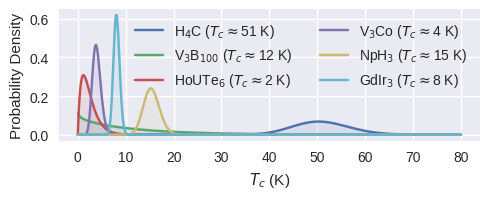

In [193]:
from scipy.stats import gamma
from sctk.materials import Material

%matplotlib inline

plt.figure(figsize=(5,2.1))
for ex, preds in example_tc_preds.items():
    
    row_data = enriched_pred_df[enriched_pred_df['mp-id'] == ex].iloc[0]
    mat = Material(row_data['Formula'])
    
    mean, std = preds[0], preds[1]
    
    kappa = mean**2/std**2
    theta = std**2/mean
    
    t = np.linspace(0,80, 1000)
    prob = gamma.pdf(t,a=kappa, scale=theta)
    
    print(mat.str(), mean, std)
    plt.plot(t,prob, label=mat.str(fmt='latex') + r' ($T_c \approx$' + f'{mean:.0f} K)')
    plt.fill_between(t,prob, alpha=0.1)
plt.ylabel('Probability Density')
plt.xlabel(r'$T_c$ (K)')
plt.legend(ncol=2)
#plt.yscale('log')
plt.tight_layout()

# save figure:
if FIGURES_DIR is not None:
    figpath = os.path.join(FIGURES_DIR,'supercon2_example_tc_preds.pdf')
    plt.savefig(figpath, backend='pgf')
plt.show()